## Import modules

In [1]:
import pandas as pd
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
import preprocessor as p
import time
from data_collection_and_preprocessing import clean_tweets
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score

## Import data

In [2]:
#final_data = pd.read_csv('C:/Users/ZIAD/Desktop/Gradution/final_data.csv')
final_data = pd.read_csv('E:/Data/Gradution project/Term1 final Gradution project/Memtal health data/Raw data in the model/data_final.csv')

In [3]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329593 entries, 0 to 329592
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   filtered_tweet  329593 non-null  object
 1   is_depression   329593 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 5.0+ MB


In [4]:
#Check for duplicates before saving
final_data.drop_duplicates(inplace= True)
final_data.shape

(329218, 2)

In [5]:
final_data['is_depression'].value_counts()

0    168927
1    160291
Name: is_depression, dtype: int64

## Data analysis

We need to analyze the frequencies of the words in the two classes and visualize them to discover which words affect the depression label.

In [14]:
depressed_data = final_data[final_data['is_depression'] == 1] 
not_depressed_data = final_data[final_data['is_depression'] == 0]

In [15]:
depressed_text = " ".join(i for i in depressed_data.filtered_tweet ) #get all words in the depressed tweets
not_depressed_text = " ".join(i for i in not_depressed_data.filtered_tweet) #get all words in the non depressed tweets

We use the word cloud graph to show the most frequent words in each class

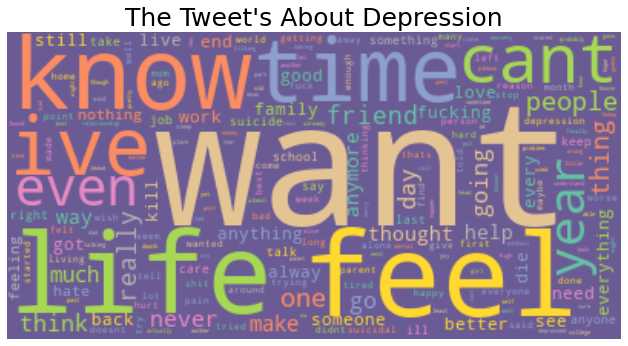

In [16]:
wordcloud = WordCloud(
    background_color="#6B5B95",
    colormap="Set2",
    collocations=False).generate(depressed_text)

plt.figure(figsize=[11,11])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("The Tweet's About Depression",size = 25)
plt.show()

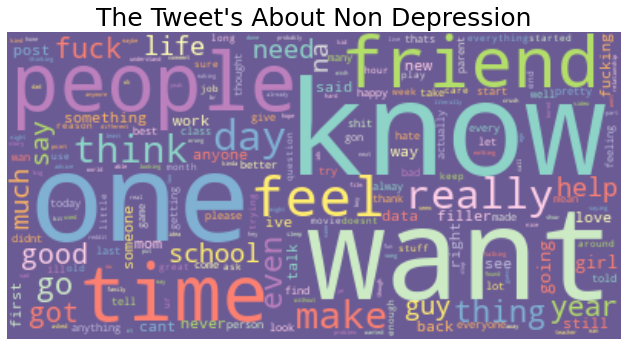

In [17]:
wordcloud = WordCloud(
    background_color="#6B5B95",
    colormap="Set3",
    collocations=False).generate(not_depressed_text)

plt.figure(figsize=[11,11])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("The Tweet's About Non Depression",size = 25)
plt.show()

We want to show the frequencies as numerical counts

In [18]:
depressed_text_counts = WordCloud().process_text(depressed_text) #count each word frequency in the depressed tweets

In [19]:
depressed_text_counts = pd.DataFrame.from_dict(depressed_text_counts.items())
depressed_text_counts.columns = ['word','count']
depressed_text_counts

,word,count
0,today,6313
1,taking,1313
2,moment,4886
3,reflect,202
4,far,2532
...,...,...
309832,nftgiveaways mentalhealth,2
309833,mentalhealth mushroomhead,2
309834,xjixiuinun divya,1
309835,divya gandotra,1


In [20]:
depressed_text_counts.sort_values(by = 'count',ascending = False).head(15)

,word,count
187249,want die,15093
49,think,13549
62,one,12554
351,work,11529
35,still,11426
1077,well,11211
464,better,10627
185029,year old,10367
185320,gon na,10151
185568,every day,9871


## Split data

In [6]:
X = final_data['filtered_tweet']
y = final_data["is_depression"].values

In [7]:
x_train,x_test,y_train,y_test=train_test_split(X, y, test_size=0.05, random_state=42, shuffle=True)

## Models

Here we defined some functions for text transformation, training the model, testing, and evaluation.

In [8]:
def pipeline_model(model):

    """
    This function used for transform the text and training the model.

    Parameters
    ----------
    func : The function of the model in sklearn

    Returns
    -------
    obj  : The fitted model and its running time

    """

    t0 = time.time()

    model = Pipeline([
    ('vect', CountVectorizer(max_features=30000)),
    ('tfidf', TfidfTransformer()),
    ('model', model)]) 

    model = model.fit(x_train, y_train) #Train model

    model_time = time.time() - t0  #Run time

    print("Training time (s):  {0:.5f}".format(model_time))

    return model,model_time


In [9]:
def model_train_results(pip_model):
    
    """
    This function is used to evaluate the model on the training data using the accuracy measure.

    Parameters
    ----------
    func : The function of the pipeline_model which trained the model.

    It shows the accuracy of the model on the training data.
    
    """

    predictions = pip_model.predict(x_train)

    score = accuracy_score(y_train, predictions)
    
    print('Accuracy score for train data {}'.format(score))

In [10]:
def model_test_results(pip_model):

    """
    This function is used to evaluate the model on the test data using the accuracy measure and Confusion matrix.

    Parameters
    ----------
    func : The function of the pipeline_model which trained the model.

    It shows the Confusion matrix, senstivity, specificity and the accuracy.

    """

    predictions = pip_model.predict(x_test)

    score = accuracy_score(y_test, predictions)

    print('Accuracy score for test data {}'.format(score))

    cm = confusion_matrix(y_test, predictions,labels=[0, 1])

    print(classification_report(y_test, predictions))

    tn, fp, fn, tp = cm.ravel()

    specificity = tn / (tn+fp)

    senstivity = tp / (tp+fn)

    print("Senstivity:", senstivity)

    print("Specificity:", specificity)

    print('Confusion matrix:')
    
    sns.heatmap(cm/np.sum(cm),fmt='.2%',cmap="BuPu",annot=True)

In [11]:
def cross_validation_score(pip_model):
    """
    This function is used to evaluate the model on the test data using the mean cross validation accuracy.

    Parameters
    ----------
    func : The function of the pipeline_model which trained the model.

    It shows the mean accuracy for 5-fold cross validation

    """
    scores = cross_val_score(pip_model, x_train, y_train, cv=5)
    
    print("Mean cross validation score ", scores.mean())

In [12]:
def auc_roc(pip_model,model_name):

    """
    This function is used to evaluate the model on the test data using the auc and roc curve.

    Parameters
    ----------
    func : The function of the pipeline_model which trained the model.
    str  : The model name for the roc curve title

    It shows the auc score and roc curve for the model.

    """

    fpr = {}
    tpr = {}
    thresh ={}

    prob_pred_LR = pip_model.predict_proba(x_test) #The probabilities of the classes

    print('roc_auc_score for the model:', roc_auc_score(y_test, prob_pred_LR[:,1])) #auc score
    
    n_class = 2
    #plot the roc curve for each class
    for i in range(n_class):    
        fpr[i], tpr[i], thresh[i] = roc_curve(y_test, prob_pred_LR[:,i], pos_label=i)
    
    # plotting
    plt.subplots(1, figsize=(10,10))
    plt.plot(fpr[0], tpr[0], linestyle='--',color='blue', label='Class 0')
    plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1')
    plt.plot([0, 1], ls="--",color = 'y')
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.title('Receiver Operating Characteristic - {}'.format(model_name))    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')  

## Multinomial Naive Bayes

### Search optimal hyperparameters

In [13]:
parameters = {'clf__alpha': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]}
mnb_best = Pipeline([
    ('vect', CountVectorizer(max_features=30000)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB(fit_prior = False))])
clf = GridSearchCV(mnb_best, parameters)
clf.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(max_features=30000)),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        MultinomialNB(fit_prior=False))]),
             param_grid={'clf__alpha': [1e-05, 0.0001, 0.001, 0.1, 1, 10, 100,
                                        1000]})

In [14]:
Model_best = clf.best_estimator_
print("Best parameter (CV score=%0.3f):" % clf.best_score_)
print(clf.best_params_)

Best parameter (CV score=0.862):
{'clf__alpha': 0.1}


### Train

In [24]:
mnb,mnb_run_time = pipeline_model(MultinomialNB(alpha =  0.1, fit_prior = False))

Training time (s):  18.95608


In [25]:
model_train_results(mnb)

Accuracy score for train data 0.8694097973826326


### Test and evaluation

Accuracy score for test data 0.8595468076058562
              precision    recall  f1-score   support

           0       0.89      0.83      0.86      8423
           1       0.83      0.89      0.86      8038

    accuracy                           0.86     16461
   macro avg       0.86      0.86      0.86     16461
weighted avg       0.86      0.86      0.86     16461

Senstivity: 0.8930082109977606
Specificity: 0.8276148640626855
Confusion matrix:


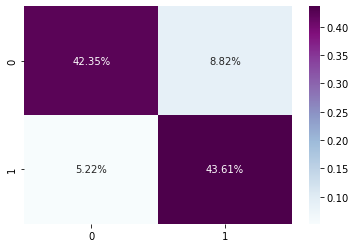

In [26]:
model_test_results(mnb)

In [54]:
cross_validation_score(mnb)

Mean cross validation score  0.8610646645960122


roc_auc_score for the model: 0.9330200572568204


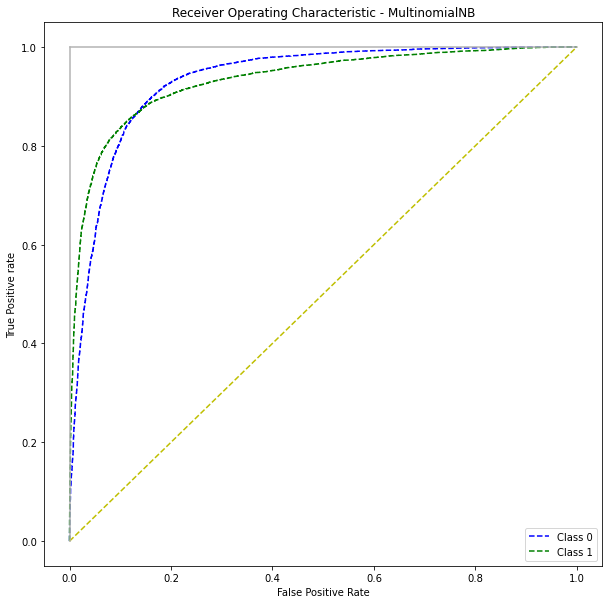

In [20]:
auc_roc(mnb,"MultinomialNB")

## Stochastic gradient descent

### Search optimal hyperparameters

In [15]:
parameters = {'clf__loss':('log', 'modified_huber','hinge'), 'clf__penalty':['elasticnet','l2'],
'clf__max_iter':[25,50,75],'clf__alpha': [.0001]}
SGDClf = Pipeline([
    ('vect', CountVectorizer(max_features=30000)),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier())])
clf = GridSearchCV(SGDClf, parameters)
clf.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(max_features=30000)),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf', SGDClassifier())]),
             param_grid={'clf__alpha': [0.0001],
                         'clf__loss': ('log', 'modified_huber', 'hinge'),
                         'clf__max_iter': [25, 50, 75],
                         'clf__penalty': ['elasticnet', 'l2']})

In [16]:
Model_best = clf.best_estimator_
print("Best parameter (CV score=%0.3f):" % clf.best_score_)
print(clf.best_params_)

Best parameter (CV score=0.888):
{'clf__alpha': 0.0001, 'clf__loss': 'modified_huber', 'clf__max_iter': 50, 'clf__penalty': 'l2'}


### Train model

In [44]:
SGDClf,SGDClf_run_time = pipeline_model(SGDClassifier(loss= 'modified_huber', penalty='l2',
                          alpha=.0001, random_state=42,
                          max_iter=60, tol=None,learning_rate ='adaptive',eta0 = 0.01,fit_intercept= False))

Training time (s):  33.39784


In [45]:
model_train_results(SGDClf)

Accuracy score for train data 0.887510111684151


### Test and evaluation

Accuracy score for test data 0.8737622258672013
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      8423
           1       0.87      0.87      0.87      8038

    accuracy                           0.87     16461
   macro avg       0.87      0.87      0.87     16461
weighted avg       0.87      0.87      0.87     16461

Senstivity: 0.8726051256531475
Specificity: 0.8748664371364122
Confusion matrix:


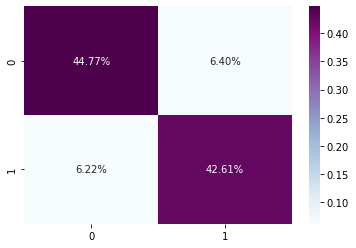

In [46]:
model_test_results(SGDClf)

In [71]:
cross_validation_score(SGDClf)

Mean cross validation score  0.887395007863122


roc_auc_score for the model: 0.9441054536836292


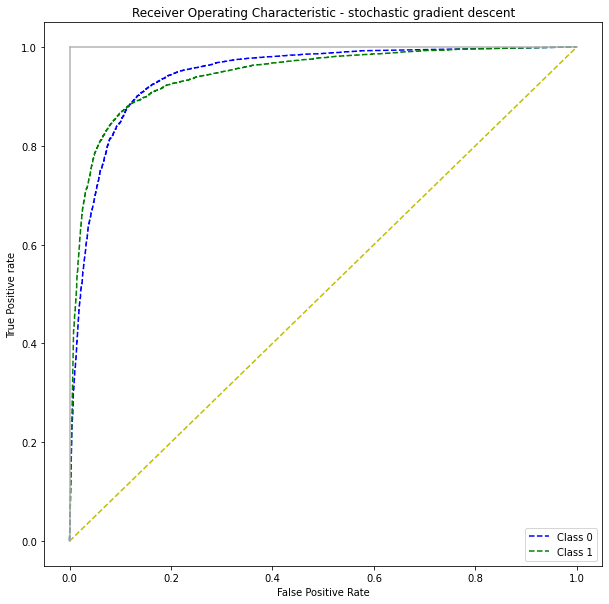

In [72]:
auc_roc(SGDClf,"stochastic gradient descent")

## DecisionTreeClassifier

### Search optimal hyperparameters

In [ ]:
parameters = {'clf__criterion':('gini', 'entropy'), 'clf__max_depth' : [20,30,40],
'clf__min_samples_split': [50,75,100]}
DTClf = Pipeline([
    ('vect', CountVectorizer(max_features=5000)),
    ('tfidf', TfidfTransformer()),
    ('clf', DecisionTreeClassifier(random_state=42))])
clf = GridSearchCV(DTClf, parameters)
clf.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(max_features=5000)),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'clf__criterion': ('gini', 'entropy'),
                         'clf__max_depth': [20, 30, 40],
                         'clf__min_samples_split': [50, 75, 100]})

In [ ]:
Model_best = clf.best_estimator_
print("Best parameter (CV score=%0.3f):" % clf.best_score_)
print(clf.best_params_)

Best parameter (CV score=0.816):
{'clf__criterion': 'gini', 'clf__max_depth': 20, 'clf__min_samples_split': 100}


### Train model

In [13]:
DTClf,DTClf_run_time = pipeline_model(DecisionTreeClassifier(criterion ='gini',max_depth= 20, min_samples_split= 100,random_state=42))

Training time (s):  161.85913


In [14]:
model_train_results(DTClf)

Accuracy score for train data 0.8484222575354029


### Test and evaluation

Accuracy score for test data 0.8267419962335216
              precision    recall  f1-score   support

           0       0.79      0.90      0.84      8423
           1       0.88      0.75      0.81      8038

    accuracy                           0.83     16461
   macro avg       0.83      0.83      0.83     16461
weighted avg       0.83      0.83      0.83     16461

Senstivity: 0.7510574769843245
Specificity: 0.898967113854921
Confusion matrix:


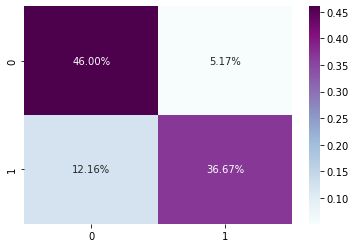

In [15]:
model_test_results(DTClf)

roc_auc_score for the model: 0.8687664054012468


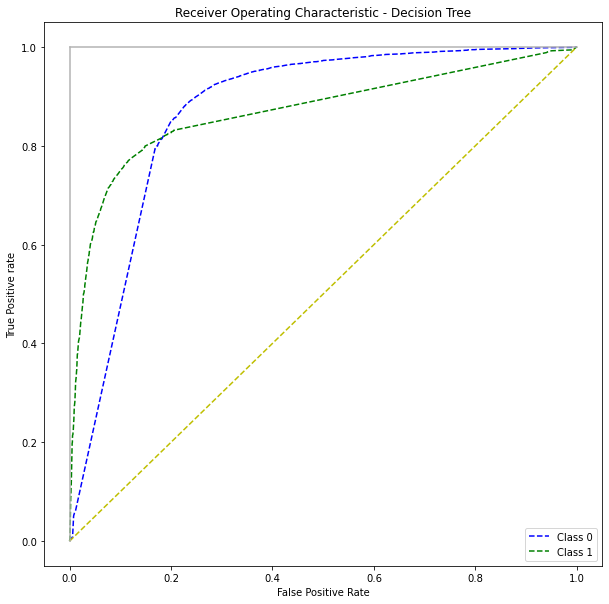

In [16]:
auc_roc(DTClf,"Decision Tree")

## RandomForestClassifier

### Search optimal hyperparameters

In [27]:
param_grid = { 
    'clf__n_estimators': [200, 500],
    'clf__max_features': ['sqrt', 'log2'],
    'clf__max_depth' : [20,30],
    'clf__criterion' :['gini', 'entropy'],
    'clf__min_samples_split': [50,75]
}
RF = Pipeline([
    ('vect', CountVectorizer(max_features=5000)),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(random_state=42))])
CV_rfc = GridSearchCV(estimator=RF, param_grid=param_grid,n_jobs = -1)
CV_rfc.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(max_features=5000)),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__criterion': ['gini', 'entropy'],
                         'clf__max_depth': [20, 30],
                         'clf__max_features': ['sqrt', 'log2'],
                         'clf__min_samples_split': [50, 75],
                         'clf__n_estimators': [200, 500]})

In [ ]:
Model_best = clf.best_estimator_
print("Best parameter (CV score=%0.3f):" % clf.best_score_)
print(clf.best_params_)

### Train model

In [21]:
RFClf,RFClf_run_time = pipeline_model(RandomForestClassifier(n_estimators = 100,criterion ='entropy',max_depth= 30, min_samples_split= 50,
max_features='sqrt',random_state=42))

Training time (s):  243.82706


In [22]:
model_train_results(RFClf)

Accuracy score for train data 0.8373113951086626


### Test and evaluation

Accuracy score for test data 0.818905291294575
              precision    recall  f1-score   support

           0       0.78      0.90      0.84      8423
           1       0.88      0.73      0.80      8038

    accuracy                           0.82     16461
   macro avg       0.83      0.82      0.82     16461
weighted avg       0.83      0.82      0.82     16461

Senstivity: 0.7289126648420005
Specificity: 0.9047845185800784
Confusion matrix:


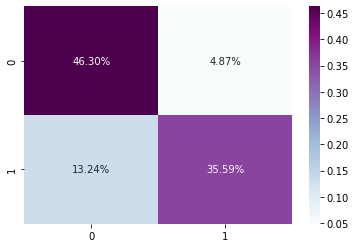

In [23]:
model_test_results(RFClf)

roc_auc_score for the model: 0.8865569079343734


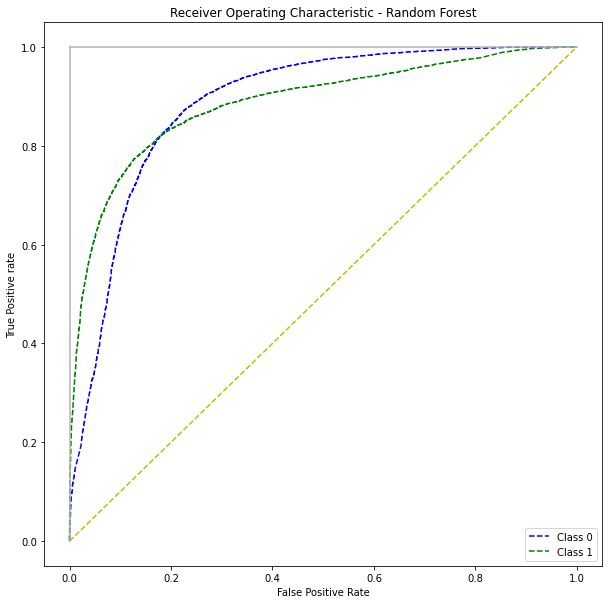

In [24]:
auc_roc(RFClf,"Random Forest")

## KNeighborsClassifier

### Search optimal hyperparameters

In [29]:
KNN = Pipeline([
    ('vect', CountVectorizer(max_features=5000)),
    ('tfidf', TfidfTransformer()),
    ('clf',KNeighborsClassifier())])

param_grid = {'clf__n_neighbors' : [3,5,9,13,15]}
CV_KNN = GridSearchCV(KNN, param_grid)
CV_KNN.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(max_features=5000)),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf', KNeighborsClassifier())]),
             param_grid={'clf__n_neighbors': [3, 5, 9, 13, 15]})

In [30]:
Model_best = CV_KNN.best_estimator_
print("Best parameter (CV score=%0.3f):" % CV_KNN.best_score_)
print(CV_KNN.best_params_)

Best parameter (CV score=0.562):
{'clf__n_neighbors': 5}


### Train model

In [30]:
knn,knn_run_time = pipeline_model(KNeighborsClassifier(n_neighbors=5))

Training time (s):  19.36389


In [26]:
model_train_results(knn)

c:\Users\ZIAD\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Accuracy score for train data 0.6049520874033195


### Test model

c:\Users\ZIAD\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Accuracy score for test data 0.7412672377133831
              precision    recall  f1-score   support

           0       0.71      0.83      0.77      8423
           1       0.79      0.65      0.71      8038

    accuracy                           0.74     16461
   macro avg       0.75      0.74      0.74     16461
weighted avg       0.75      0.74      0.74     16461

Senstivity: 0.645434187608858
Specificity: 0.8327199335153745
Confusion matrix:


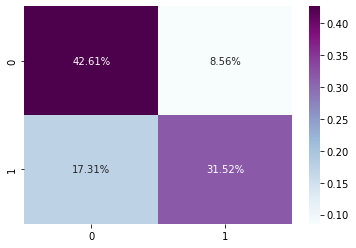

In [31]:
model_test_results(knn)

roc_auc_score for the model: 0.804841212361903


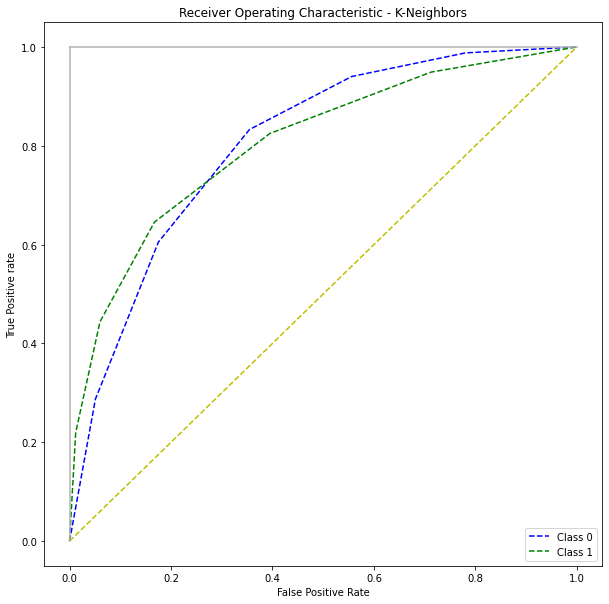

In [32]:
auc_roc(knn,"K-Neighbors")

## Conclusion

We can see that MNB and SGD have a higher performance and lower run time we will use them for deployment.

## Test the models

In [37]:
# Define a list of text data representing tweets
text = ['I am so sad','The product is bad',"I am happy", "He is honest man.", "I have a terrible day","I have a terrible life"," the product is horrible", "I love her" , "I can't understand"
        ,"I am disapointed" ,"The product ugly","This man is good bit i did't love him","I'm very depressed.","I am so sad and not happy","This food is healthy but has the imperfect taste"
        ,"I hate twitter","May the Force be with you.","Mr. Stark, I don't feel so good","Mister Stark, I'm not feeling well.","I feel badly",
        'https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html','محمد احمد السيد يحب اخوه','西班牙人口众多',
        'Spanien har en stor befolkning','https://ar.wikipedia.org/wiki/%D9%85%D8%AD%D9%85%D8%AF_%D8%B1%D9%85%D8%B6%D8%A7%D9%86_(%D9%85%D9%85%D8%AB%D9%84)',
        'Elon Musk (@elonmusk) / Twitter']

# Create an empty list to store the preprocessed tweets
cleaned_tweets = []

# Iterate over each tweet in the text list
for t in (text):
    tweet = t
    # Apply the p.clean function to remove URLs, mentions, and other unwanted text from the tweet
    clean_text = p.clean(tweet)
    # Apply the clean_tweets function to further preprocess the tweet
    filtered_tweet = clean_tweets(clean_text)
    # Store the preprocessed tweet in the cleaned_tweets list
    cleaned_tweets.append(filtered_tweet)

# Make binary predictions for depression-related tweets using the Multinomial Naive Bayes and Stochastic Gradient Descent classifiers
mnb_deperesed = mnb.predict(cleaned_tweets)
sgd_deperesed = SGDClf.predict(cleaned_tweets)

# Make probability predictions for depression-related tweets using the Multinomial Naive Bayes and Stochastic Gradient Descent classifiers
mnb_pro= mnb.predict_proba(cleaned_tweets)[:,1]
sgd_pro = SGDClf.predict_proba(cleaned_tweets)[:,1]

# Calculate the average of the predicted probabilities from both classifiers
avg_pro = (mnb_pro + sgd_pro)/2

# Make a list of binary labels indicating whether each tweet is related to depression or not
true = [0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0]

# Create a Pandas DataFrame to store the preprocessed text, predicted classes, predicted probabilities, and true labels for each tweet
df = pd.DataFrame({'text': text,'cleaned_text': cleaned_tweets, 'mnb_Class': mnb_deperesed,'sgd_Class': sgd_deperesed, 'sgd_prop':sgd_pro,'mnb_prop':mnb_pro, 'avg_pro':avg_pro,'true':true})
# Create an empty list to store the predicted binary labels
predictions = []

# Iterate over each row in the DataFrame
for i in range(len(df)):
    # If the average predicted probability of depression-related tweets is greater than 0.55, predict that the tweet is related to depression
    if df.avg_pro[i] > 0.55:
        prediction = 1
    # Otherwise, predict that the tweet is not related to depression
    else:
        prediction = 0
    # Append the predicted label to the predictions list
    predictions.append(prediction)

# Add thepredicted binary labels to the DataFrame
df['predictions'] =predictions

# Replace the binary labels in the DataFrame with "Not depressed" and "depressed"
df = df.replace([0,1], ["Not depressed","depressed"])
df

,text,cleaned_text,mnb_Class,sgd_Class,sgd_prop,mnb_prop,avg_pro,true,predictions
0,I am so sad,sad,depressed,Not depressed,0.314609,0.515361,0.414985,Not depressed,Not depressed
1,The product is bad,product bad,Not depressed,Not depressed,0.392532,0.228253,0.310393,Not depressed,Not depressed
2,I am happy,happy,depressed,Not depressed,0.164163,0.528685,0.346424,Not depressed,Not depressed
3,He is honest man.,honest man,Not depressed,Not depressed,0.262376,0.435003,0.348690,Not depressed,Not depressed
4,I have a terrible day,terrible day,depressed,depressed,0.571298,0.688167,0.629732,Not depressed,depressed
5,I have a terrible life,terrible life,depressed,depressed,0.946216,0.796241,0.871229,depressed,depressed
6,the product is horrible,product horrible,Not depressed,depressed,0.523644,0.359675,0.441660,Not depressed,Not depressed
7,I love her,love,depressed,Not depressed,0.289148,0.506431,0.397790,Not depressed,Not depressed
8,I can't understand,cant understand,depressed,depressed,0.753220,0.695314,0.724267,Not depressed,depressed
9,I am disapointed,disapointed,depressed,depressed,0.565468,0.765574,0.665521,Not depressed,depressed


In [39]:
# accuracy on this data
accuracy_score(df.true,df.predictions)

0.8076923076923077

## Save the models

In [53]:
import joblib 
joblib.dump(mnb,'E:/Data/Gradution project/Term1 final Gradution project/saved models_v2/mnb_v2.pkl')

['E:/Data/Gradution project/Term1 final Gradution project/saved models_v2/mnb_v2.pkl']

In [54]:
joblib.dump(SGDClf,'E:/Data/Gradution project/Term1 final Gradution project/saved models_v2/sgd_v2.pkl')

['E:/Data/Gradution project/Term1 final Gradution project/saved models_v2/sgd_v2.pkl']